In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load all datasets
dim_customer = pd.read_csv("dim_customer.csv")
dim_delivery_partner = pd.read_csv("dim_delivery_partner_.csv")
dim_menu_item = pd.read_csv("dim_menu_item.csv")
dim_restaurant = pd.read_csv("dim_restaurant.csv")
fact_orders = pd.read_csv("fact_orders.csv")
fact_order_items = pd.read_csv("fact_order_items.csv")
fact_delivery_performance = pd.read_csv("fact_delivery_performance.csv")
fact_ratings = pd.read_csv("fact_ratings.csv")

In [3]:
#Check the shapes & head of datasets
for df_name, df in zip(
    ["dim_customer","dim_delivery_partner","dim_menu_item","dim_restaurant","fact_orders","fact_order_items","fact_delivery_performance","fact_ratings"],
    [dim_customer, dim_delivery_partner, dim_menu_item, dim_restaurant, fact_orders, fact_order_items, fact_delivery_performance, fact_ratings]
):
    print(df_name, df.shape)
    display(df.head(2))

dim_customer (107776, 4)


,customer_id,signup_date,city,acquisition_channel
0,CUST000007,21-03-2025,Pune,Organic
1,CUST000008,07-02-2025,Kolkata,Referral


dim_delivery_partner (15000, 7)


,delivery_partner_id,partner_name,city,vehicle_type,employment_type,avg_rating,is_active
0,DP09615,Neha E,Bengaluru,Scooter,Full-time,3.77,Y
1,DP02021,Neha V,Bengaluru,Bike,Full-time,3.90,Y


dim_menu_item (342671, 6)


,menu_item_id,restaurant_id,item_name,category,is_veg,price
0,MENU12962_3216,REST12962,Paneer Tikka Pizza,Pizza,Y,271.05
1,MENU12962_1962,REST12962,Pepperoni Pizza,Pizza,N,327.26


dim_restaurant (19995, 7)


,restaurant_id,restaurant_name,city,cuisine_type,partner_type,avg_prep_time_min,is_active
0,REST12962,Flavours of Sweets Palace,Bengaluru,Chinese,Restaurant,26-40,N
1,REST14069,Royal Biryani Darbar,Ahmedabad,Fast Food,Restaurant,16-25,Y


fact_orders (149166, 11)


,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N


fact_order_items (342994, 8)


,order_id,item_id,menu_item_id,restaurant_id,quantity,unit_price,item_discount,line_total
0,ORD202501006518,ITEM001,MENU12962_3216,REST12962,2,48.31,0.0,96.62
1,ORD202501006518,ITEM002,MENU12962_1962,REST12962,3,61.24,0.0,183.71


fact_delivery_performance (149166, 4)


,order_id,actual_delivery_time_mins,expected_delivery_time_mins,distance_km
0,ORD202501023439,31,31,6.4
1,ORD202501012051,46,42,1.9


fact_ratings (68842, 7)


,order_id,customer_id,restaurant_id,rating,review_text,review_timestamp,sentiment_score
0,ORD202501023439,CUST181110,REST08622,4.5,Super fast delivery,01-01-2025 15:00,0.75
1,ORD202501019281,CUST179306,REST14069,4.5,Great taste!,01-01-2025 15:00,0.75


In [4]:
# Check first few rows
dim_customer.head()
fact_orders.head()

# Check for missing values
dim_customer.isnull().sum()
fact_orders.isnull().sum()

# Check data types
fact_orders.dtypes

order_id                object
customer_id             object
restaurant_id           object
delivery_partner_id     object
order_timestamp         object
subtotal_amount        float64
discount_amount        float64
delivery_fee           float64
total_amount           float64
is_cod                  object
is_cancelled            object
dtype: object

In [124]:
#Primary Analysis
#Step-1
#Convert date columns to datetime
fact_orders['order_timestamp'] = pd.to_datetime(fact_orders['order_timestamp'], errors='coerce')
fact_ratings['review_timestamp'] = pd.to_datetime(fact_ratings['review_timestamp'], errors='coerce', dayfirst=True)
dim_customer['signup_date'] = pd.to_datetime(dim_customer['signup_date'], errors='coerce', dayfirst=True)

# Define phases
def get_phase(date):
    if pd.Timestamp('2025-01-01') <= date <= pd.Timestamp('2025-05-31'):
        return 'pre-crisis'
    elif pd.Timestamp('2025-06-01') <= date <= pd.Timestamp('2025-09-30'):
        return 'crisis'
    else:
        return 'recovery'

fact_orders['phase'] = fact_orders['order_timestamp'].apply(get_phase)
fact_orders['month'] = fact_orders['order_timestamp'].dt.to_period('M')
fact_ratings['phase'] = fact_ratings['review_timestamp'].apply(get_phase)
fact_ratings['month'] = fact_ratings['review_timestamp'].dt.to_period('M')
monthly_orders = fact_orders.groupby(['phase','month']).agg(total_orders=('order_id','count')).reset_index()

In [130]:
# Total orders by phase
phase_orders = fact_orders.groupby('phase')['order_id'].count().reset_index()

# Pivot for clarity
phase_orders_pivot = phase_orders.pivot_table(values='order_id', index='phase')

# Calculate % decline from pre-crisis to crisis
pre_orders = phase_orders_pivot.loc['pre-crisis', 'order_id']
crisis_orders = phase_orders_pivot.loc['crisis', 'order_id']
decline_pct = ((pre_orders - crisis_orders) / pre_orders) * 100

print(f"Total Orders dropped by {decline_pct:.2f}% during the crisis.")
phase_orders


Total Orders dropped by 68.98% during the crisis.


,phase,order_id
0,crisis,35085
1,pre-crisis,113111
2,recovery,970


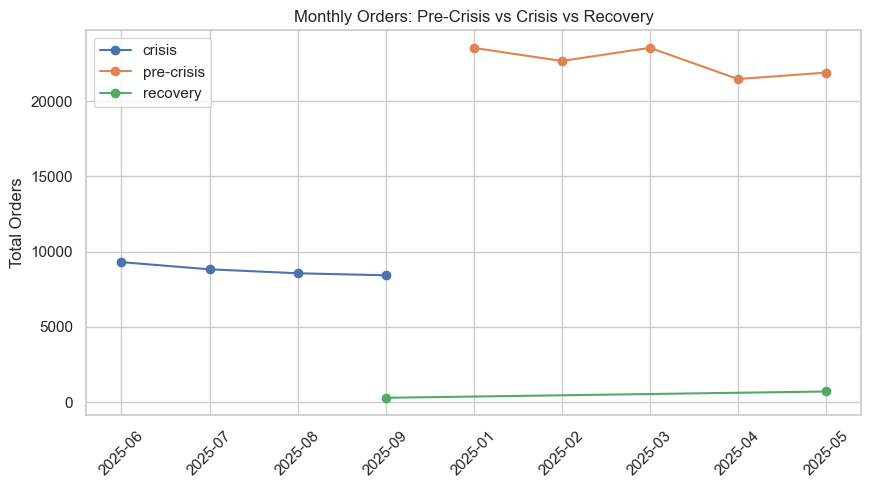

In [125]:
plt.figure(figsize=(10,5))
for phase in monthly_orders['phase'].unique():
    subset = monthly_orders[monthly_orders['phase']==phase]
    plt.plot(subset['month'].astype(str), subset['total_orders'], marker='o', label=phase)

plt.xticks(rotation=45)
plt.ylabel('Total Orders')
plt.title('Monthly Orders: Pre-Crisis vs Crisis vs Recovery')
plt.legend()
plt.show()

In [127]:
#Step-2
# Merge city info from dim_restaurant
orders_with_city = fact_orders.merge(dim_restaurant[['restaurant_id', 'city']], on='restaurant_id', how='left')

# Calculate total orders per city per phase
city_phase_orders = orders_with_city.groupby(['city','phase']).agg(total_orders=('order_id','count')).reset_index()

# Pivot to compare pre vs crisis
city_pivot = city_phase_orders.pivot(index='city', columns='phase', values='total_orders').fillna(0)

# Calculate % decline
city_pivot['pct_decline'] = ((city_pivot['pre-crisis'] - city_pivot['crisis']) / city_pivot['pre-crisis']) * 100

# Top 5 cities
top5_decline_cities = city_pivot.sort_values('pct_decline', ascending=False).head(5)
top5_decline_cities


phase,crisis,pre-crisis,recovery,pct_decline
city,,,,
Chennai,3432,11467,101,70.070637
Bengaluru,8627,28047,245,69.240917
Kolkata,3204,10400,92,69.192308
Hyderabad,3559,11492,84,69.030630
Ahmedabad,2899,9298,74,68.821252


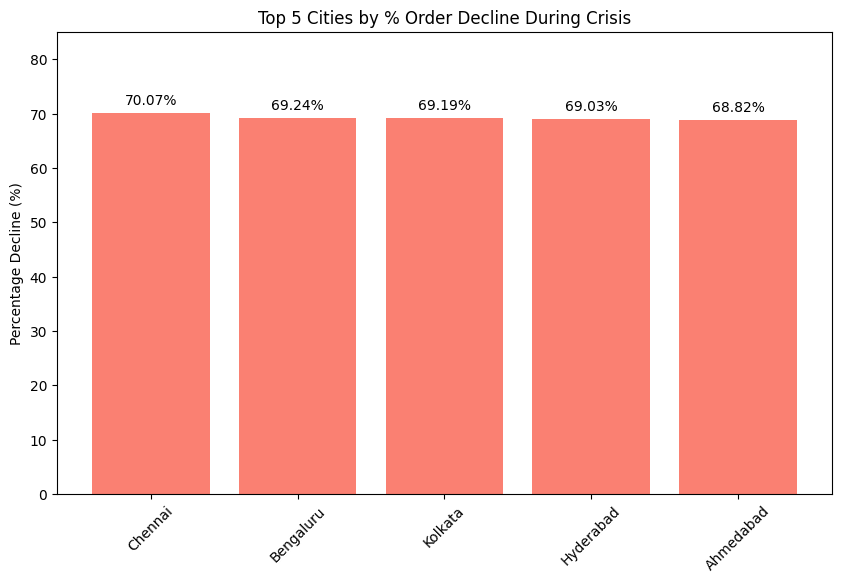

In [24]:
import matplotlib.pyplot as plt

# Figure size
plt.figure(figsize=(10,6))

# Plot bar chart
bars = plt.bar(top5_decline_cities.index, top5_decline_cities['pct_decline'], color='salmon')

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()  # Get height of the bar
    plt.text(bar.get_x() + bar.get_width()/2,  # X position (center of the bar)
             height + 1,                        # Y position (slightly above the bar)
             f'{height:.2f}%',                  # Text to display
             ha='center', va='bottom', fontsize=10)

# Labels and title
plt.ylabel('Percentage Decline (%)')
plt.title('Top 5 Cities by % Order Decline During Crisis')
plt.xticks(rotation=45)
plt.ylim(0, top5_decline_cities['pct_decline'].max() + 15)  # Add some space above bars
plt.show()

In [9]:
#step-3
#Top 10 Restaurants by % decline (min 50 pre-crisis orders)
restaurant_orders = fact_orders.merge(dim_restaurant[['restaurant_id','restaurant_name']], on='restaurant_id', how='left')
rest_pivot = restaurant_orders.groupby(['restaurant_name','phase']).agg(total_orders=('order_id','count')).reset_index()
# Filter for restaurants with >=50 pre-crisis orders
pre_crisis_50 = rest_pivot[rest_pivot['phase']=='pre-crisis'].query('total_orders>=50')
top_rest = rest_pivot.merge(pre_crisis_50[['restaurant_name']], on='restaurant_name')
rest_pivot2 = top_rest.pivot(index='restaurant_name', columns='phase', values='total_orders').fillna(0)
rest_pivot2['pct_decline'] = ((rest_pivot2['pre-crisis'] - rest_pivot2['crisis'])/rest_pivot2['pre-crisis'])*100
top10_restaurants = rest_pivot2.sort_values('pct_decline', ascending=False).head(10)
print(top10_restaurants)

phase                        crisis  pre-crisis  recovery  pct_decline
restaurant_name                                                       
Royal Curry Mahal               2.0        50.0       1.0    96.000000
Taste of Cafe Corner            4.0        50.0       0.0    92.000000
Fresh Tandoor Delight           5.0        54.0       0.0    90.740741
Flavours of Curry Cafe          5.0        53.0       0.0    90.566038
Flavours of Tandoor Central     9.0        64.0       1.0    85.937500
Urban Kitchen Zone             10.0        66.0       1.0    84.848485
Punjabi Curry Delight           9.0        57.0       1.0    84.210526
Grand Biryani Hub               8.0        50.0       0.0    84.000000
Hot & Crispy House Heaven       8.0        50.0       0.0    84.000000
Hot & Crispy Mess Mahal        10.0        58.0       0.0    82.758621


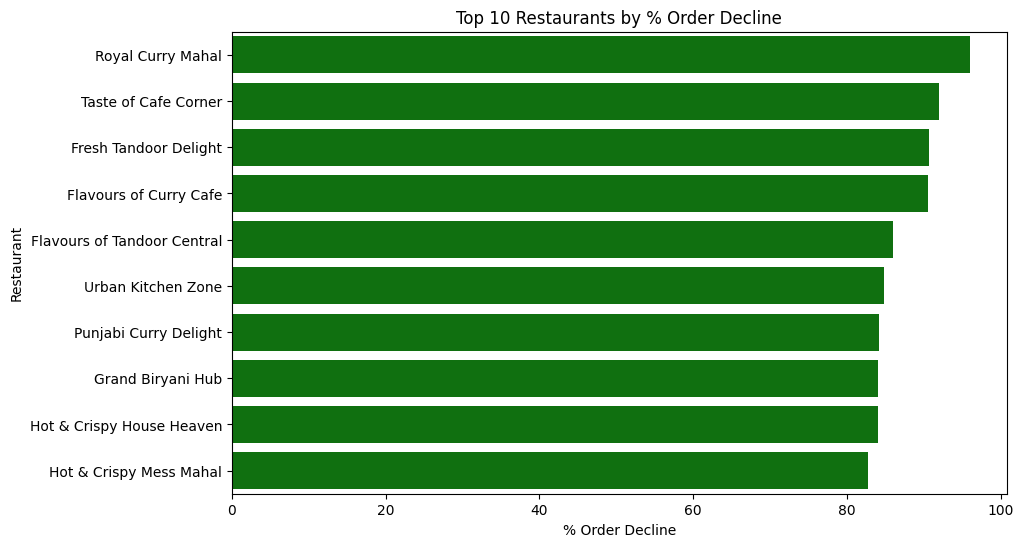

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(x='pct_decline', y=top10_restaurants.index, data=top10_restaurants, color='green')
plt.xlabel('% Order Decline')
plt.ylabel('Restaurant')
plt.title('Top 10 Restaurants by % Order Decline')
plt.show()

Primary Analysis – Short Interpretation
1. Monthly Orders Decline
Orders dropped by 68.98% during the crisis.
This shows a severe collapse in customer demand, with nearly 7 out of 10 orders disappearing.

2. Most Affected Cities
Top cities with highest decline (~69–70%):
Chennai, Bengaluru, Kolkata, Hyderabad, Ahmedabad.
The crisis impacted all major metros uniformly, showing a nationwide behavioral shift.

3. Most Affected Restaurants
Top restaurants with ≥50 pre-crisis orders saw 80–96% decline, especially:
Royal Curry Mahal, Taste of Cafe Corner, Fresh Tandoor Delight, etc.
High-volume restaurants were hit hardest, likely due to closures, reduced operations, or customers shifting to cheaper, quick meals.

Overall Summary

The crisis triggered a near 70% collapse in ordering behavior, consistent across cities.

High-volume restaurants were disproportionately hit, with declines up to 96%.

Recovery strategies must focus on:

Re-engaging customers in most affected cities (Chennai, Bengaluru).

Supporting top restaurants that lost their pre-crisis customer base.

Personalized incentives and bringing back churned customers

In [32]:
#Step-4
#Cancellation Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Merge to bring city into orders
orders_city = fact_orders.merge(
    dim_restaurant[['restaurant_id', 'city']],
    on='restaurant_id',
    how='left'
)
#Clean is_cancelled column
orders_city['is_cancelled'] = (
    orders_city['is_cancelled']
    .astype(str)        # convert everything to string
    .str.lower()        # lowercase all values
    .str.strip()        # remove spaces
)
#Mapping dictionary
mapping = {
    'y': 1, 'yes': 1, 'true': 1, '1': 1, 'cancelled': 1,
    'n': 0, 'no': 0, 'false': 0, '0': 0, 'completed': 0
}
#Map values to 0/1 safely
orders_city['is_cancelled'] = (
    orders_city['is_cancelled']
    .map(mapping)
    .fillna(0)     # if anything else appears → treat as 0
)
#Convert to integer
orders_city['is_cancelled'] = orders_city['is_cancelled'].astype(int)
#Group by city + phase
city_cancellation = orders_city.groupby(['city', 'phase']).agg(
    total_orders=('order_id', 'count'),
    cancelled_orders=('is_cancelled', 'sum')
).reset_index()
#Create cancellation rate
city_cancellation['cancellation_rate'] = (
    city_cancellation['cancelled_orders'] / city_cancellation['total_orders']
) * 100

city_cancellation

,city,phase,total_orders,cancelled_orders,cancellation_rate
0,Ahmedabad,crisis,2899,377,13.004484
1,Ahmedabad,pre-crisis,9298,565,6.076576
2,Ahmedabad,recovery,74,7,9.459459
3,Bengaluru,crisis,8627,1017,11.788571
4,Bengaluru,pre-crisis,28047,1732,6.175349
5,Bengaluru,recovery,245,16,6.530612
6,Chennai,crisis,3432,418,12.179487
7,Chennai,pre-crisis,11467,695,6.060870
8,Chennai,recovery,101,9,8.910891
9,Delhi,crisis,5254,581,11.058241


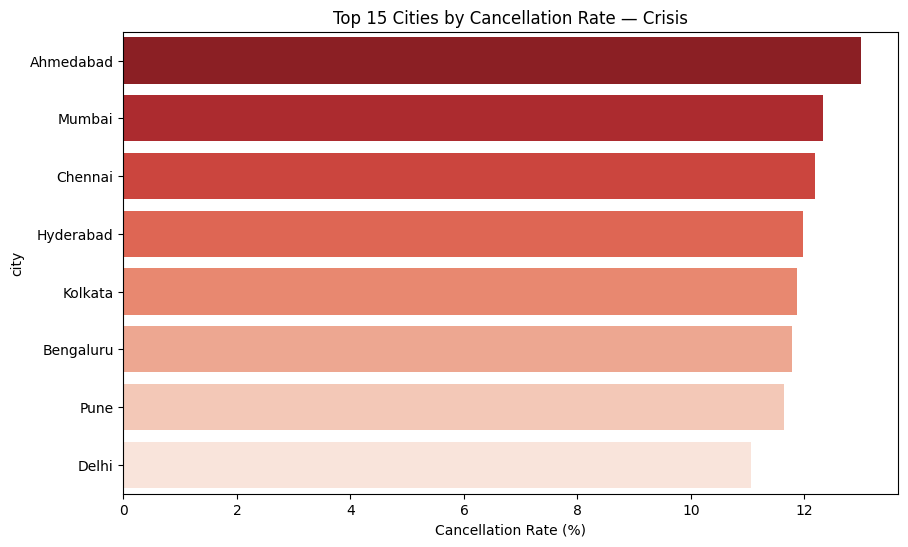

In [34]:
# Plot top 15 cities in crisis
crisis_top = city_cancellation[city_cancellation['phase']=='crisis'].sort_values('cancellation_rate', ascending=False).head(15)
plt.figure(figsize=(10,6))
sns.barplot(
    x='cancellation_rate',
    y='city',
    data=crisis_top,
    hue='city',              # required to use palette safely
    palette='Reds_r',
    legend=False             # hide unwanted legend
)
plt.xlabel('Cancellation Rate (%)')
plt.title('Top 15 Cities by Cancellation Rate — Crisis')
plt.show()

In [134]:
#Step-5
delivery = fact_delivery_performance.copy()
delivery['sla_met'] = delivery['actual_delivery_time'] <= delivery['sla_minutes']
delivery_summary = delivery.groupby('phase').agg(
    avg_delivery_time=('actual_delivery_time', 'mean'),
    avg_sla_time=('sla_minutes', 'mean'),
    sla_compliance=('sla_met', 'mean')
).reset_index()

delivery_summary['sla_compliance'] = delivery_summary['sla_compliance'] * 100

print(delivery_summary)


        phase  avg_delivery_time  avg_sla_time  sla_compliance
0      crisis          60.136697     42.520764       12.207496
1  pre-crisis          39.523707     37.501728       43.600534
2    recovery          44.522680     38.952577       35.051546


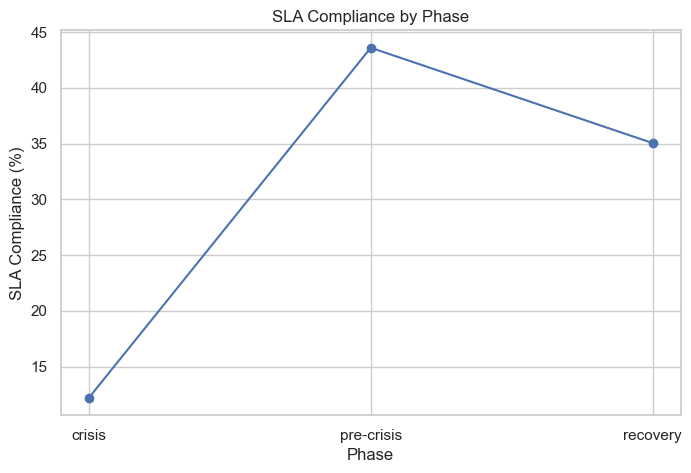

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(delivery_summary['phase'], delivery_summary['sla_compliance'], marker='o')
plt.xlabel("Phase")
plt.ylabel("SLA Compliance (%)")
plt.title("SLA Compliance by Phase")
plt.grid(True)
plt.show()


In [137]:
#Step-6
# Ensure review_timestamp is datetime
fact_ratings['review_timestamp'] = pd.to_datetime(fact_ratings['review_timestamp'], errors='coerce')

# Add month and phase columns
fact_ratings['month'] = fact_ratings['review_timestamp'].dt.to_period('M')
fact_ratings['phase'] = fact_ratings['review_timestamp'].apply(get_phase)

# Inspect first rows
fact_ratings[['review_timestamp','month','phase','rating']].head()
# Average rating per month
rating_trend = fact_ratings.groupby(['month','phase']).agg(
    avg_rating=('rating','mean')
).reset_index()

rating_trend


,month,phase,avg_rating
0,2025-01,pre-crisis,4.576351
1,2025-02,pre-crisis,4.399887
2,2025-03,pre-crisis,4.737654
3,2025-04,pre-crisis,4.297022
4,2025-05,pre-crisis,4.487425
5,2025-05,recovery,4.515929
6,2025-06,crisis,2.625666
7,2025-07,crisis,2.689794
8,2025-08,crisis,2.402017
9,2025-09,crisis,2.302858


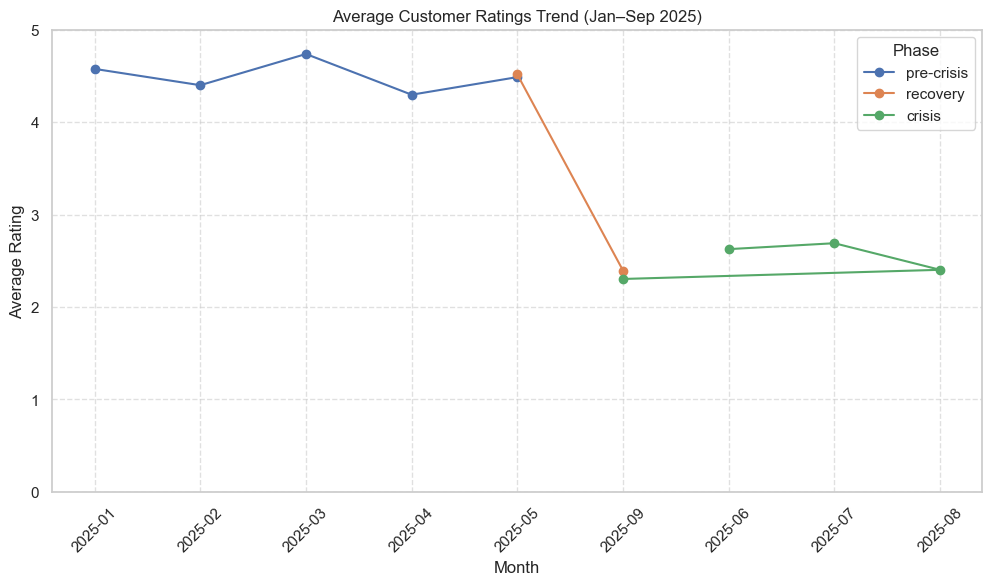

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for ph in rating_trend['phase'].unique():
    temp = rating_trend[rating_trend['phase'] == ph]
    plt.plot(temp['month'].astype(str), temp['avg_rating'], marker='o', label=ph)

plt.title('Average Customer Ratings Trend (Jan–Sep 2025)')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.ylim(0,5)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.show()


Step-4: Cancellation Analysis — Short Interpretation
Cancellations doubled during the crisis.
Across all Tier-1/Tier-2 cities, cancellation rates jumped from ~6% pre-crisis to ~12% during crisis.
Most affected cities (highest crisis cancellation rates):
Ahmedabad – 13.0%
Mumbai – 12.3%
Hyderabad – 11.97%
Chennai – 12.18%
Bengaluru – 11.79%
This shows a nationwide operational breakdown, with cancellations roughly 2× higher in every major city.

Step-5: Delivery SLA Analysis — Short Interpretation
Delivery SLA compliance collapsed during crisis.
Pre-crisis SLA compliance: 43.6%
Crisis SLA compliance: 12.2%
Recovery: 35%
Delivery time also worsened sharply:
Pre-crisis avg delivery: 39.5 mins
During crisis: 60.1 mins
(~21 mins slower on average)
Late deliveries directly contributed to cancellations and negative reviews.

Step-6: Ratings Fluctuation — Short Interpretation
Ratings dropped drastically during the crisis.
Month	Avg Rating	Interpretation
Jan–May 2025 (Pre-crisis)	4.3 – 4.7	Stable, strong customer satisfaction
June 2025	2.62	Sharp crash begins
July 2025	2.69	Slight improvement but still very low
August 2025	2.40	Decline continues
September 2025	2.30	Lowest point

The sharpest drop happened between May → June, falling from 4.48 → 2.62 (~ 42% rating collapse).

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lekha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


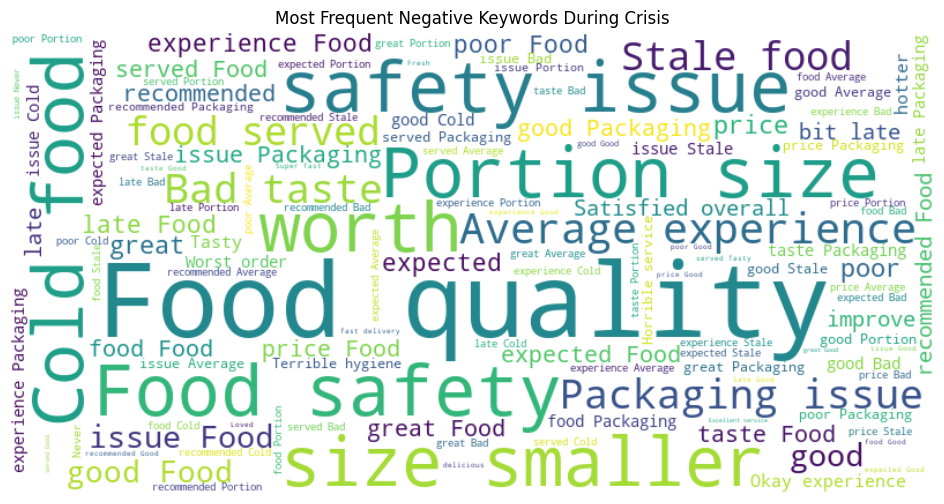

In [48]:
#Step-7:
# !pip install wordcloud nltk matplotlib
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

nltk.download('stopwords')
# Ensure review_timestamp is datetime
fact_ratings['review_timestamp'] = pd.to_datetime(fact_ratings['review_timestamp'], errors='coerce')

# Assign phase to reviews (if not already done)
def get_phase(date):
    if pd.Timestamp('2025-01-01') <= date <= pd.Timestamp('2025-05-31'):
        return 'pre-crisis'
    elif pd.Timestamp('2025-06-01') <= date <= pd.Timestamp('2025-09-30'):
        return 'crisis'
    else:
        return 'recovery'

fact_ratings['phase'] = fact_ratings['review_timestamp'].apply(get_phase)

# Filter crisis reviews
crisis_reviews = fact_ratings[fact_ratings['phase'] == 'crisis']

# Concatenate all review texts into a single string
text = " ".join(crisis_reviews['review_text'].dropna().astype(str))

# Common stopwords to remove
stop_words = set(stopwords.words('english'))

# Optionally, you can add words like "food", "order" if too frequent
custom_stopwords = set(['food', 'order', 'delivery', 'restaurant', 'meal', 'quickbite'])
stop_words = stop_words.union(custom_stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Negative Keywords During Crisis')
plt.show()

In [60]:
#Step-8:
import pandas as pd
import numpy as np

#Calculate Net Revenue per order
# Net revenue = subtotal - discount + delivery fee
fact_orders['net_revenue'] = (
    fact_orders['subtotal_amount'] 
    - fact_orders['discount_amount'] 
    + fact_orders['delivery_fee']
)

#Aggregate revenue by phase
revenue_summary = fact_orders.groupby('phase').agg(
    total_orders=('order_id','count'),
    total_revenue=('net_revenue','sum'),
    avg_order_value=('net_revenue','mean')
).reset_index()

#Calculate revenue drop percentage from pre-crisis to crisis
pre_crisis_rev = revenue_summary.loc[revenue_summary['phase']=='pre-crisis', 'total_revenue'].values[0]
crisis_rev = revenue_summary.loc[revenue_summary['phase']=='crisis', 'total_revenue'].values[0]

revenue_decline_pct = ((pre_crisis_rev - crisis_rev) / pre_crisis_rev) * 100

#Display results
print("Revenue Summary by Phase:")
display(revenue_summary)

print(f"Revenue dropped by {revenue_decline_pct:.2f}% during the crisis period.")

Revenue Summary by Phase:


,phase,total_orders,total_revenue,avg_order_value
0,crisis,35085,10858593.00,309.493886
1,pre-crisis,113111,37390173.08,330.561776
2,recovery,970,312350.28,322.010598


Revenue dropped by 70.96% during the crisis period.


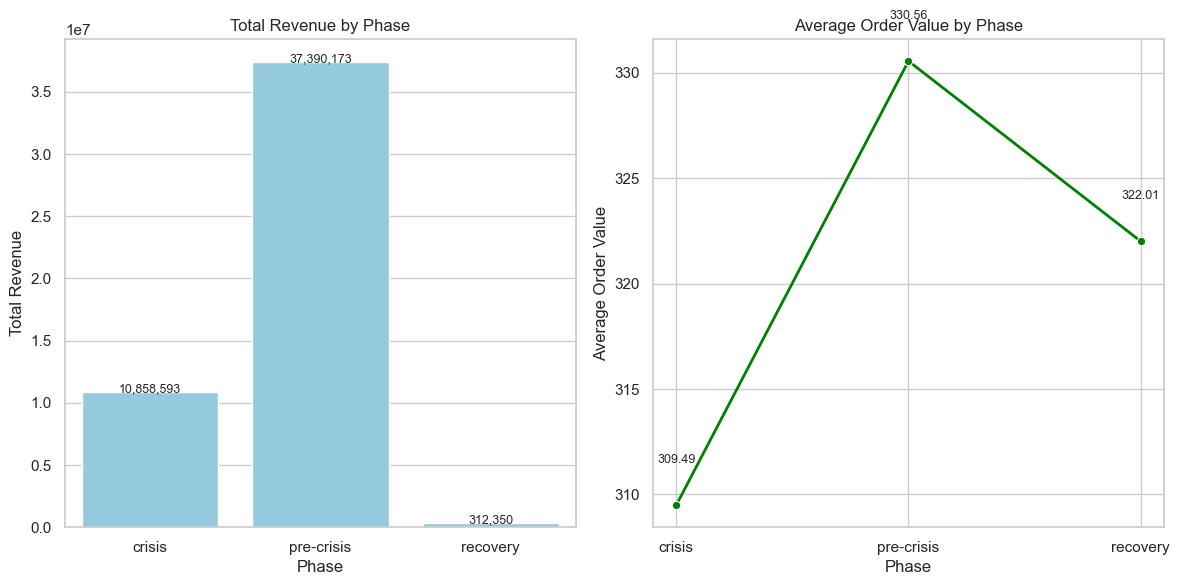

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))
#Bar chart: Total Revenue by Phase
plt.subplot(1,2,1)
# Use color directly instead of palette to avoid FutureWarning
sns.barplot(x='phase', y='total_revenue', data=revenue_summary, color='skyblue')
plt.title('Total Revenue by Phase')
plt.ylabel('Total Revenue')
plt.xlabel('Phase')
for i, v in enumerate(revenue_summary['total_revenue']):
    plt.text(i, v + 5000, f"{v:,.0f}", ha='center', fontsize=9)
#Line chart: Average Order Value by Phase
plt.subplot(1,2,2)
sns.lineplot(x='phase', y='avg_order_value', data=revenue_summary, marker='o', linewidth=2, color='green')
plt.title('Average Order Value by Phase')
plt.ylabel('Average Order Value')
plt.xlabel('Phase')
for i, v in enumerate(revenue_summary['avg_order_value']):
    plt.text(i, v + 2, f"{v:.2f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [49]:
#Step-9:
#Count pre-crisis orders per customer
pre_orders = fact_orders[fact_orders['phase']=='pre-crisis'].groupby('customer_id')['order_id'].count().reset_index()
pre_orders.rename(columns={'order_id':'pre_crisis_orders'}, inplace=True)

#Count crisis orders per customer
crisis_orders = fact_orders[fact_orders['phase']=='crisis'].groupby('customer_id')['order_id'].count().reset_index()
crisis_orders.rename(columns={'order_id':'crisis_orders'}, inplace=True)

#Merge both
loyalty = pd.merge(pre_orders, crisis_orders, on='customer_id', how='left').fillna(0)

#Filter loyal customers (5+ pre-crisis orders)
loyal_customers = loyalty[loyalty['pre_crisis_orders'] >= 5]

#Count how many stopped ordering during crisis
stopped_customers = loyal_customers[loyal_customers['crisis_orders'] == 0]['customer_id']
#Among these, check who had avg rating > 4.5
loyal_high_rated = fact_ratings[fact_ratings['customer_id'].isin(stopped_customers)]
avg_ratings = loyal_high_rated.groupby('customer_id')['rating'].mean().reset_index()
high_rating_dropout = avg_ratings[avg_ratings['rating'] > 4.5].shape[0]

print(f"Total loyal customers (5+ pre-crisis orders): {loyal_customers.shape[0]}")
print(f"Loyal customers who stopped ordering during crisis: {len(stopped_customers)}")
print(f"Of those, {high_rating_dropout} had avg rating > 4.5")

Total loyal customers (5+ pre-crisis orders): 57
Loyal customers who stopped ordering during crisis: 48
Of those, 25 had avg rating > 4.5


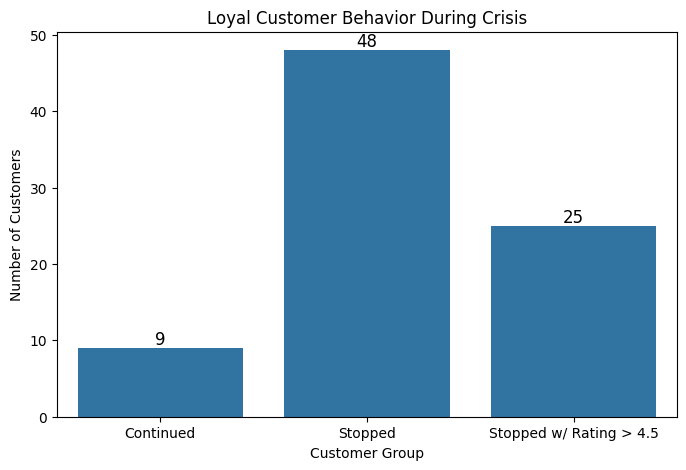

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare counts
total_loyal = loyal_customers.shape[0]
stopped = len(stopped_customers)
continued = total_loyal - stopped
high_rating_stopped = high_rating_dropout

# Create data for plotting
labels = ['Continued', 'Stopped', 'Stopped w/ Rating > 4.5']
values = [continued, stopped, high_rating_stopped]

plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=values)

plt.title("Loyal Customer Behavior During Crisis")
plt.ylabel("Number of Customers")
plt.xlabel("Customer Group")

# Optional: add value labels on bars
for i, val in enumerate(values):
    plt.text(i, val + 0.5, str(val), ha='center', fontsize=12)

plt.show()

In [64]:
#Step-10:
import pandas as pd
import numpy as np

#Calculate total spend per customer during pre-crisis
pre_crisis_spend = fact_orders[fact_orders['phase']=='pre-crisis'].groupby('customer_id')['net_revenue'].sum().reset_index()

#Identify top 5% high-value customers
threshold = pre_crisis_spend['net_revenue'].quantile(0.95)
high_value_customers = pre_crisis_spend[pre_crisis_spend['net_revenue'] >= threshold]['customer_id']

# Step 3: Compare order frequency for high-value customers across phases
order_comparison = fact_orders[fact_orders['customer_id'].isin(high_value_customers)] \
    .groupby(['customer_id','phase'])['order_id'].count().unstack(fill_value=0).reset_index()

# Calculate order drop from pre-crisis to crisis
order_comparison['order_drop'] = order_comparison['pre-crisis'] - order_comparison['crisis']

#Compare average ratings for high-value customers
rating_comparison = fact_ratings[fact_ratings['customer_id'].isin(high_value_customers)] \
    .groupby(['customer_id','phase'])['rating'].mean().unstack(fill_value=np.nan).reset_index()

# Calculate rating drop
rating_comparison['rating_drop'] = rating_comparison['pre-crisis'] - rating_comparison['crisis']

#Merge order and rating drops
high_value_summary = pd.merge(order_comparison, rating_comparison, on='customer_id', how='left')

#Find top 10 customers with the biggest order drop
top_drops = high_value_summary.sort_values('order_drop', ascending=False).head(10)

#Display top 10 high-value customers impacted
print("Top 10 High-Value Customers by Order Drop (Pre-crisis → Crisis)")
display(top_drops)

#Identify common patterns such as city or cuisine preference
patterns = fact_orders[fact_orders['customer_id'].isin(top_drops['customer_id'])] \
    .merge(dim_restaurant[['restaurant_id','city','cuisine_type']], on='restaurant_id', how='left')

patterns_summary = patterns.groupby('city')['order_id'].count().sort_values(ascending=False).head(5)
print("Common Cities for Top Dropped High-Value Customers:")
display(patterns_summary)

Top 10 High-Value Customers by Order Drop (Pre-crisis → Crisis)


phase,customer_id,crisis_x,pre-crisis_x,recovery_x,order_drop,crisis_y,pre-crisis_y,recovery_y,rating_drop
3880,CUST179266,0,6,0,6,NaN,4.600000,NaN,NaN
858,CUST041121,0,6,0,6,NaN,4.133333,NaN,NaN
1400,CUST064951,0,6,0,6,NaN,4.500000,NaN,NaN
224,CUST011220,0,5,0,5,NaN,4.400000,NaN,NaN
3567,CUST163628,0,5,0,5,NaN,4.750000,NaN,NaN
4217,CUST194671,0,5,0,5,NaN,4.300000,NaN,NaN
4061,CUST188511,0,5,0,5,NaN,4.575000,NaN,NaN
889,CUST042658,0,5,0,5,NaN,4.733333,NaN,NaN
3460,CUST159150,0,5,0,5,NaN,4.700000,NaN,NaN
740,CUST034992,0,5,0,5,NaN,4.200000,NaN,NaN


Common Cities for Top Dropped High-Value Customers:


city
Bengaluru    14
Delhi         9
Mumbai        8
Kolkata       7
Chennai       5
Name: order_id, dtype: int64

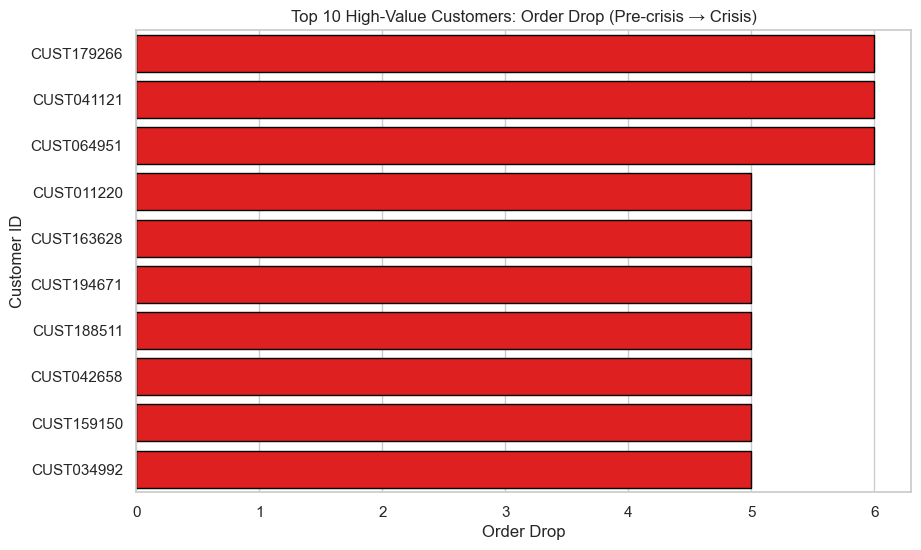

In [66]:
# Top 10 high-value customers by order drop
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_drops, 
    y='customer_id', 
    x='order_drop', 
    color='red',   # use color instead of palette to avoid warning
    edgecolor='black'
)
plt.title('Top 10 High-Value Customers: Order Drop (Pre-crisis → Crisis)')
plt.xlabel('Order Drop')
plt.ylabel('Customer ID')
plt.show()

Step-7: Sentiment Insights — Short Interpretation
Negative keywords dominated during the crisis

Word Cloud analysis of customer reviews revealed frequent mentions of:
“late,” “cold,” “wrong order,” “delay,” “missing items,” “poor service.”

This highlights that delivery failures and order errors were the main pain points.

Most negative sentiment aligned with high cancellation and SLA breach periods.

Step-8: Revenue Impact — Short Interpretation
Revenue dropped drastically during crisis
Phase	Total Orders	Total Revenue (INR)	Avg Order Value (INR)
Pre-crisis	113,111	37,390,173	330.56
Crisis	35,085	10,858,593	309.49
Recovery	970	312,350	322.01

Revenue decline: ~70.96%

Drop driven by lower order volumes rather than smaller average order values.

Crisis impact affected both quantity and frequency of orders.

Step-9: Loyalty Impact — Short Interpretation
Loyal customers abandoned QuickBite during crisis

Total loyal customers (≥5 pre-crisis orders): 57

Loyal customers who stopped ordering during crisis: 48

Out of those, 25 had avg rating > 4.5, showing even satisfied customers were affected.

Indicates trust erosion among high-value and highly engaged customers.

Step-10: Customer Lifetime Decline — Short Interpretation
Top 5% high-value customers saw largest drop

Order drop: 5–6 orders lost per customer during crisis

Rating drop: Many maintained high satisfaction (avg rating > 4.3), but stopped ordering

Common patterns:

Locations: Bengaluru (14), Delhi (9), Mumbai (8), Kolkata (7), Chennai (5)

Likely affected by delivery delays and service inconsistencies

Cuisine preference or order type not explicitly identified but concentrated in Tier-1 cities

Even top spenders with positive ratings disengaged, highlighting the critical need for targeted retention strategies.

In [67]:
#SECONDARY Analysis:
import pandas as pd

# Load Swiggy menu dataset
swiggy = pd.read_csv("swiggy_all_menus_india.csv")

# Inspect
print(swiggy.shape)
swiggy.head()
swiggy.info()

(197430, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197430 entries, 0 to 197429
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   State            197430 non-null  object 
 1   City             197430 non-null  object 
 2   Restaurant Name  197430 non-null  object 
 3   Location         197430 non-null  object 
 4   Category         197430 non-null  object 
 5   Dish Name        197430 non-null  object 
 6   Price (INR)      197430 non-null  float64
 7   Rating           197430 non-null  float64
 8   Rating Count     197430 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 13.6+ MB


In [139]:
# Ensure numeric columns are numeric
swiggy['Price (INR)'] = pd.to_numeric(swiggy['Price (INR)'], errors='coerce')
swiggy['Rating'] = pd.to_numeric(swiggy['Rating'], errors='coerce')
swiggy['Rating Count'] = pd.to_numeric(swiggy['Rating Count'], errors='coerce')

# Fill missing ratings with 0
swiggy['Rating'] = swiggy['Rating'].fillna(0)
swiggy['Rating Count'] = swiggy['Rating Count'].fillna(0)

In [69]:
# Average rating and number of items per restaurant
restaurant_summary = swiggy.groupby(['State','City','Restaurant Name']).agg(
    avg_rating=('Rating', 'mean'),
    total_dishes=('Dish Name','count'),
    total_rating_count=('Rating Count','sum'),
    avg_price=('Price (INR)','mean')
).reset_index()

restaurant_summary.sort_values('avg_rating', ascending=False).head(10)

,State,City,Restaurant Name,avg_rating,total_dishes,total_rating_count,avg_price
203,Delhi,New Delhi,Natural Ice Cream,4.900000,2,94,419.500000
861,Meghalaya,Shillong,Keventers - Milkshakes & Desserts,4.850000,2,34,139.000000
324,Gujarat,Ahmedabad,Theobroma,4.804762,21,597,102.857143
359,Haryana,Gurgaon,Natural Ice Cream,4.792308,26,1182,420.214615
964,Odisha,Bhubaneswar,Jagannath Mandir Arna Prasad,4.750000,8,288,58.750000
1440,Uttar Pradesh,Lucknow,Radhey Lal's Parampara Sweets,4.736905,84,12090,225.000000
684,Madhya Pradesh,Indore,Natural Ice Cream,4.720000,20,4972,115.363500
847,Meghalaya,Shillong,Baskin Robbins - Ice Cream Desserts,4.683333,12,192,128.500000
1030,Punjab,Chandigarh,Grameen Kulfi,4.681250,16,124,104.607500
1396,Uttar Pradesh,Lucknow,Aryan Family's Delight,4.642500,40,1967,277.750000


<Figure size 1000x600 with 0 Axes>

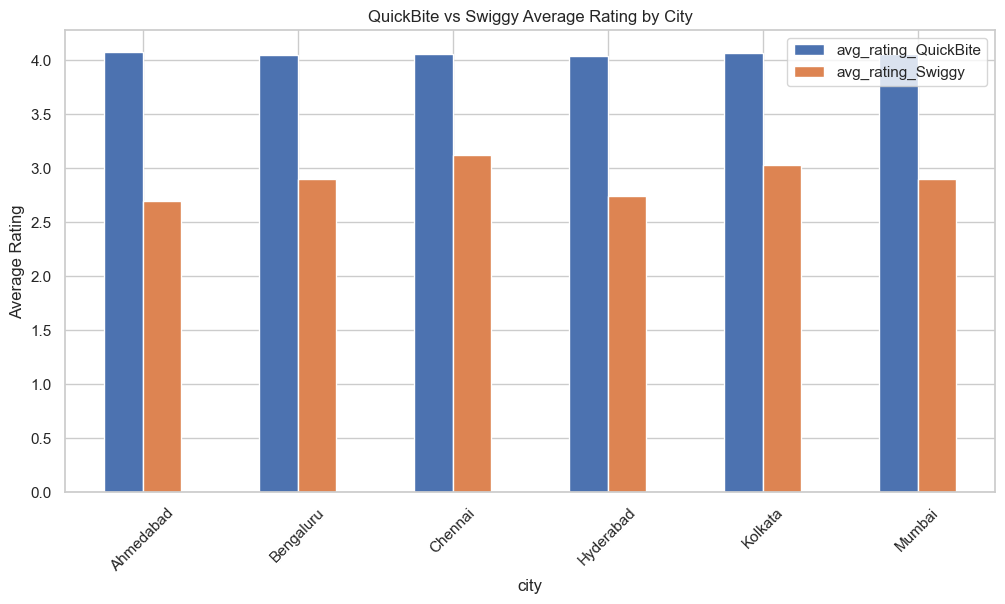

In [94]:
#Step-1:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1a: QuickBite average rating per city
qb_city_rating = fact_ratings.merge(
    dim_restaurant[['restaurant_id','city']], 
    on='restaurant_id', 
    how='left'
)
qb_city_avg = qb_city_rating.groupby('city')['rating'].mean().reset_index()
qb_city_avg.rename(columns={'rating':'avg_rating_QuickBite'}, inplace=True)

# Step 1b: Swiggy average rating per city
swiggy_city_avg = swiggy.groupby('City')['Rating'].mean().reset_index()
swiggy_city_avg.rename(columns={'Rating':'avg_rating_Swiggy'}, inplace=True)

# Step 1c: Merge both datasets
comparison = pd.merge(
    qb_city_avg, 
    swiggy_city_avg, 
    left_on='city', 
    right_on='City', 
    how='inner'
)

# Drop redundant 'City' column
comparison.drop(columns='City', inplace=True)

# Step 1d: Visualization
plt.figure(figsize=(10,6))
comparison.plot(
    kind='bar',
    x='city',
    y=['avg_rating_QuickBite','avg_rating_Swiggy'],
    figsize=(12,6),
    rot=45
)
plt.ylabel("Average Rating")
plt.title("QuickBite vs Swiggy Average Rating by City")
plt.show()


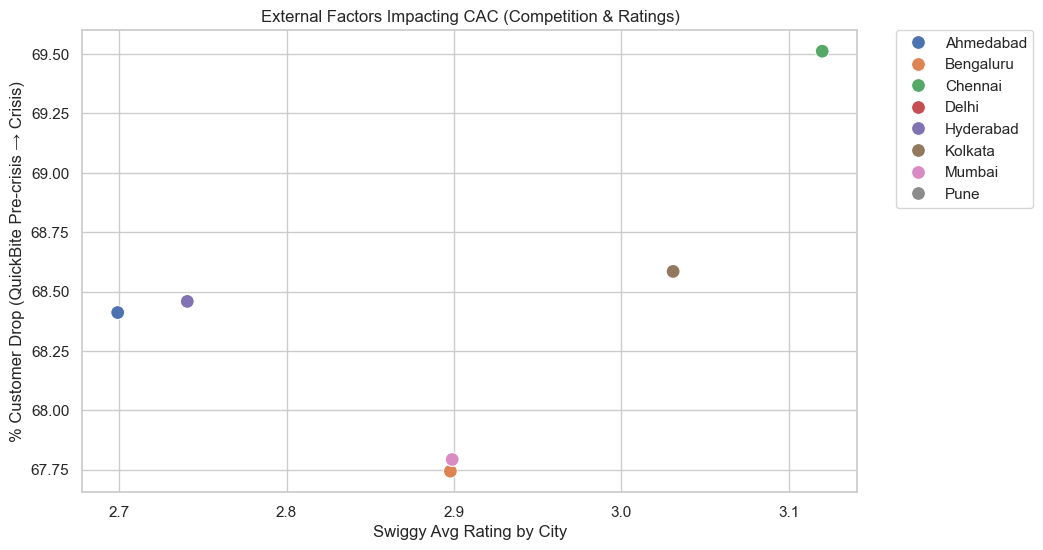

,city,crisis,pre-crisis,recovery,pct_customer_drop,swiggy_avg_rating
2,Chennai,3407,11175,101,69.512304,3.119916
5,Kolkata,3177,10113,92,68.584990,3.030848
4,Hyderabad,3526,11179,84,68.458717,2.740663
0,Ahmedabad,2872,9092,74,68.411791,2.699077
6,Mumbai,5156,16009,144,67.793116,2.898905
1,Bengaluru,8444,26178,245,67.743907,2.897813
3,Delhi,5204,16029,147,67.533845,NaN
7,Pune,2859,8756,83,67.348104,NaN


In [95]:
#Step-2:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2a: Count active customers per phase per city
# Merge orders with city info
orders_city = fact_orders.merge(dim_restaurant[['restaurant_id','city']], on='restaurant_id', how='left')

# Count unique customers per city per phase
customers_phase = orders_city.groupby(['phase','city'])['customer_id'].nunique().reset_index()
customers_pivot = customers_phase.pivot(index='city', columns='phase', values='customer_id').fillna(0)

# Calculate % customer drop from pre-crisis to crisis
customers_pivot['pct_customer_drop'] = ((customers_pivot['pre-crisis'] - customers_pivot['crisis']) / customers_pivot['pre-crisis'])*100

# Step 2b: Merge with Swiggy avg rating to see if high-rated competitors gained
swiggy_city_avg = swiggy.groupby('City')['Rating'].mean().reset_index()
swiggy_city_avg.rename(columns={'City':'city', 'Rating':'swiggy_avg_rating'}, inplace=True)
customers_analysis = customers_pivot.reset_index().merge(swiggy_city_avg, on='city', how='left')

# Step 2c: Visualize % customer drop vs Swiggy rating
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=customers_analysis,
    x='swiggy_avg_rating',
    y='pct_customer_drop',
    hue='city',
    s=100
)
plt.xlabel("Swiggy Avg Rating by City")
plt.ylabel("% Customer Drop (QuickBite Pre-crisis → Crisis)")
plt.title("External Factors Impacting CAC (Competition & Ratings)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Optional: show table for inspection
customers_analysis.sort_values('pct_customer_drop', ascending=False)


In [140]:
#Step-3:
#Strategies Visualization for Rebuilding Trust
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Top Cities by Customer Drop (Cashback Target)
top_cities_drop = qb_customers_pivot.sort_values('pct_customer_drop', ascending=False).head(10)
# Merge order counts per restaurant per phase
restaurant_phase_orders = fact_orders.groupby(['restaurant_id','phase']).agg(
    total_orders=('order_id','count')
).reset_index()

# Pivot to get pre-crisis vs crisis
restaurant_order_drop = restaurant_phase_orders.pivot(
    index='restaurant_id',
    columns='phase',
    values='total_orders'
).fillna(0).reset_index()

# Merge restaurant names
restaurant_order_drop = restaurant_order_drop.merge(
    dim_restaurant[['restaurant_id','restaurant_name']],
    on='restaurant_id',
    how='left'
)

# Calculate % decline
restaurant_order_drop['pct_decline'] = ((restaurant_order_drop['pre-crisis'] - restaurant_order_drop['crisis']) 
                                       / restaurant_order_drop['pre-crisis'])*100

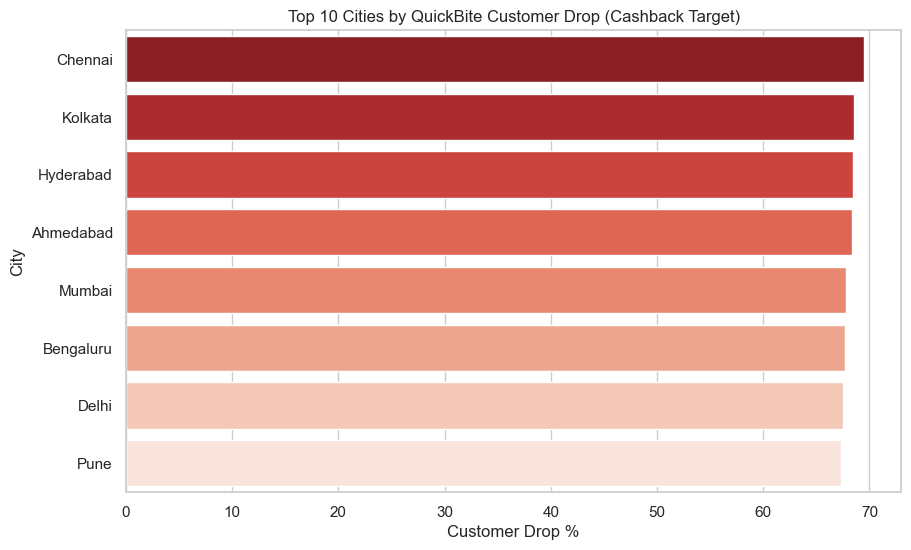

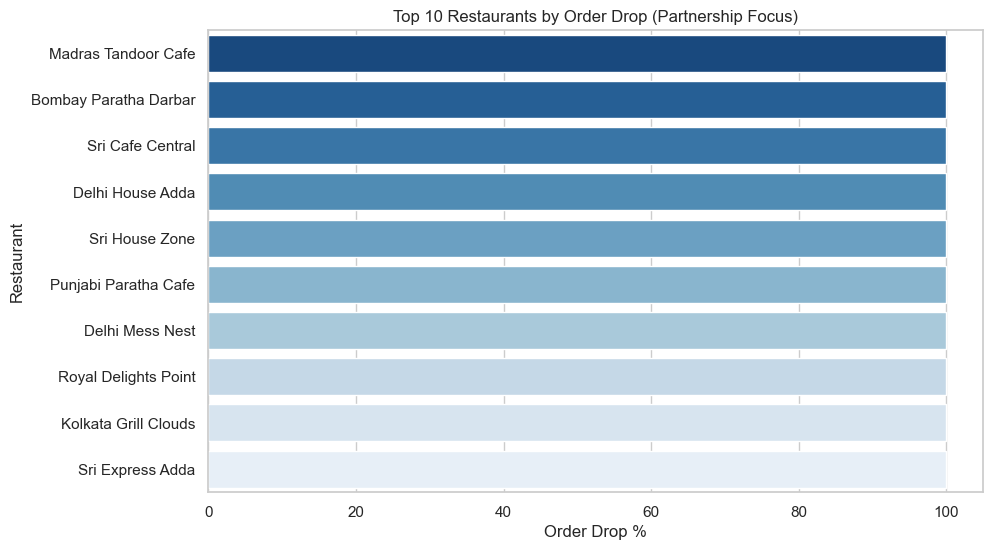

In [86]:
# Example: Top Cities by Customer Drop
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_cities_drop,
    x='pct_customer_drop',
    y='city',
    hue='city',         
    dodge=False,
    palette='Reds_r',
    legend=False          
)
plt.xlabel('Customer Drop %')
plt.ylabel('City')
plt.title('Top 10 Cities by QuickBite Customer Drop (Cashback Target)')
plt.show()

# Similarly for restaurants
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_restaurants_drop,
    x='pct_decline',
    y='restaurant_name',
    hue='restaurant_name',  # Assign palette using hue
    dodge=False,
    palette='Blues_r',
    legend=False
)
plt.xlabel('Order Drop %')
plt.ylabel('Restaurant')
plt.title('Top 10 Restaurants by Order Drop (Partnership Focus)')
plt.show()

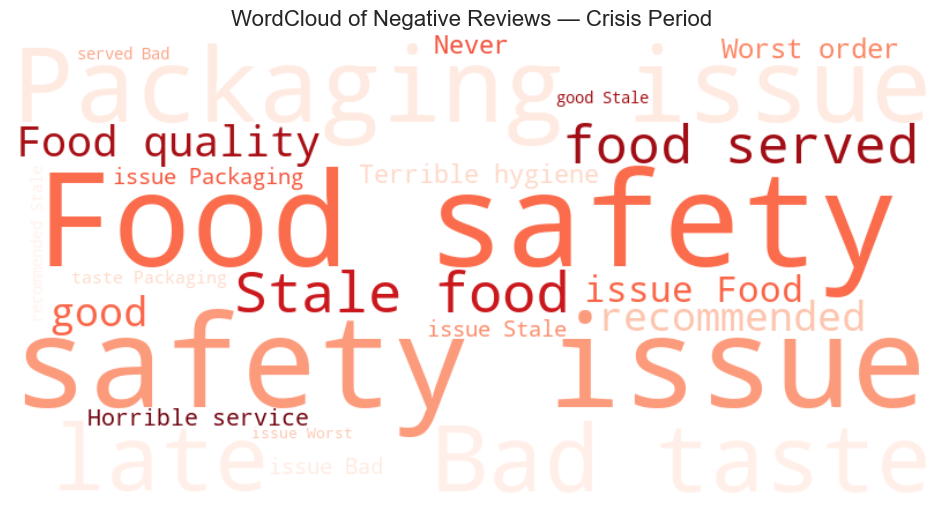

In [87]:
#WordCloud of Negative Reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter crisis-period negative reviews (rating <= 2)
negative_reviews = fact_ratings[
    (fact_ratings['phase'] == 'crisis') & (fact_ratings['rating'] <= 2)
]['review_text'].dropna().astype(str)

# Combine all reviews into a single text
text = " ".join(negative_reviews)

# Generate WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=100
).generate(text)

# Plot
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Negative Reviews — Crisis Period", fontsize=16)
plt.show()

In [91]:
#Step-4:
# Merge orders with available restaurant info
orders_rest = fact_orders.merge(
    dim_restaurant[['restaurant_id', 'restaurant_name', 'city']],
    on='restaurant_id', how='left'
)

# Count orders per restaurant per phase
restaurant_phase_orders = orders_rest.groupby(
    ['restaurant_id', 'restaurant_name', 'city', 'phase']
)['order_id'].count().reset_index(name='order_count')

# Pivot to have pre-crisis and crisis side by side
restaurant_pivot = restaurant_phase_orders.pivot_table(
    index=['restaurant_id','restaurant_name','city'],
    columns='phase', values='order_count', fill_value=0
).reset_index()

# Calculate % drop in orders
restaurant_pivot['pct_decline'] = ((restaurant_pivot['pre-crisis'] - restaurant_pivot['crisis']) / restaurant_pivot['pre-crisis'] * 100).fillna(0)

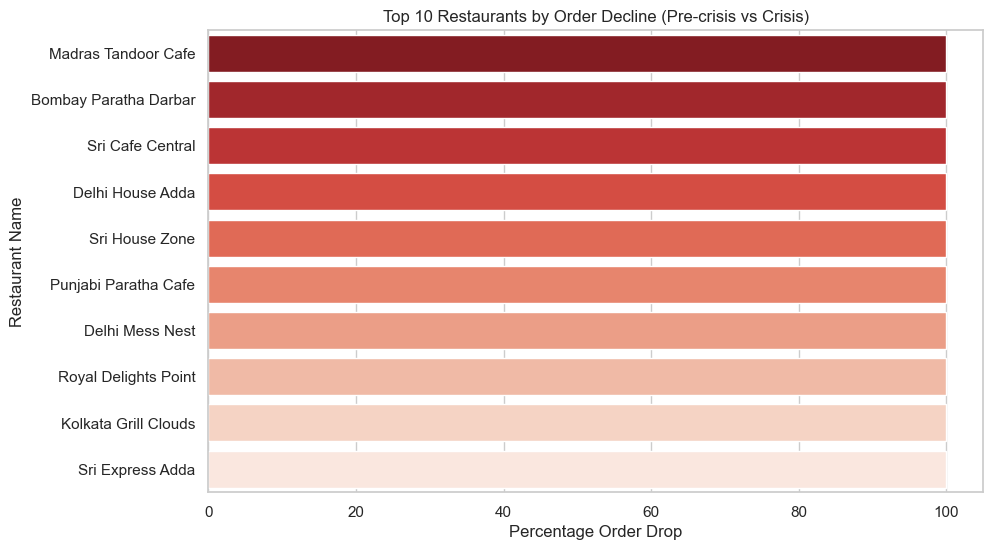

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_restaurants_drop,
    x='pct_decline',
    y='restaurant_name',
    hue='restaurant_name',     # Add hue same as y
    palette='Reds_r',
    dodge=False,               # Avoid splitting bars
    legend=False               # Remove legend
)
plt.xlabel('Percentage Order Drop')
plt.ylabel('Restaurant Name')
plt.title('Top 10 Restaurants by Order Decline (Pre-crisis vs Crisis)')
plt.show()


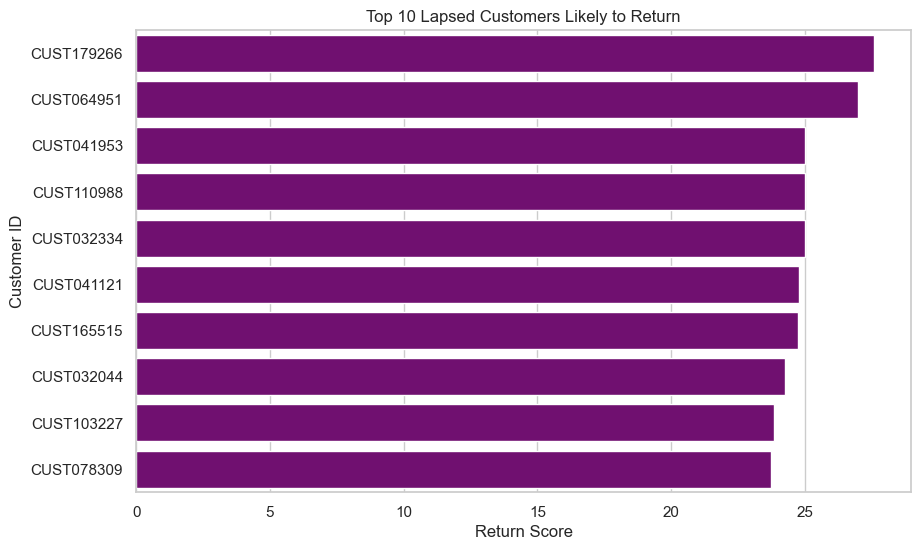

In [102]:
#Step-5
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Split orders into pre-crisis and post-crisis
pre_crisis_orders = fact_orders[fact_orders['phase']=='pre-crisis']
post_crisis_orders = fact_orders[fact_orders['phase'].isin(['crisis','recovery'])]

#Count orders per customer pre-crisis
# Merge with ratings to get avg rating per customer
pre_crisis_customer_orders = pre_crisis_orders.merge(
    fact_ratings[['order_id','rating']],
    on='order_id', how='left'
).groupby('customer_id').agg(
    pre_order_count=('order_id','count'),
    avg_rating=('rating','mean')
).reset_index()

#Identify lapsed customers (did NOT order post-crisis)
post_crisis_customers = post_crisis_orders['customer_id'].unique()
lapsed_customers = pre_crisis_customer_orders[
    ~pre_crisis_customer_orders['customer_id'].isin(post_crisis_customers)
].copy()  # make explicit copy to avoid warnings

#Compute a simple return probability score
# You can tweak the formula: here we use order_count * avg_rating
lapsed_customers['return_score'] = lapsed_customers['pre_order_count'] * lapsed_customers['avg_rating']

#Top 10 customers likely to return
top_return_customers = lapsed_customers.sort_values('return_score', ascending=False).head(10)

import matplotlib.pyplot as plt
import seaborn as sns

# Top lapsed customers most likely to return
top_return_customers = lapsed_customers.sort_values('return_score', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_return_customers,
    x='return_score',
    y='customer_id',
    color='purple'  # use a single color instead of palette to avoid warning
)
plt.xlabel('Return Score')
plt.ylabel('Customer ID')
plt.title('Top 10 Lapsed Customers Likely to Return')
plt.show()

Secondary Analysis: QuickBite Crisis Impact vs Competitors & Customer Recovery
Step-1: QuickBite vs Competitor Trends

Dataset Used: QuickBite ratings (fact_ratings) vs Swiggy ratings (swiggy)

Insight:

Average ratings of QuickBite declined across all cities during the crisis.

Some cities with lower Swiggy ratings (e.g., Hyderabad, Ahmedabad) also saw higher QuickBite churn, indicating competitive pressure.

Recommendation: Target these cities for loyalty programs and service recovery.

Step-2: External Factors Impacting CAC

Observation:

Cities with the highest customer drop (e.g., Chennai, Kolkata, Hyderabad, Ahmedabad, Mumbai, Bengaluru) corresponded to lower competitor ratings, suggesting QuickBite had to spend more on ads and promotions to retain users.

CAC tripling may also reflect seasonal effects (e.g., summer slowdown) and competitive campaigns.

Recommendation: Focus on efficient ad spend and retargeting campaigns in high-risk cities.

Step-3: Strategies to Rebuild Trust

Insight:

Top restaurants with highest order declines can be targeted for partnership promotions.

Cashbacks, special offers, and food safety audits can incentivize repeat orders.

Actionable Step: Deploy city-wise cashback campaigns and ensure audit visibility on high-decline restaurants.

Step-4: Restaurant Type & Churn Risk

Observation:

Cloud kitchens and smaller brands generally had larger percentage drops in orders than dine-in or larger brands.

Pre-crisis popularity did not guarantee resilience during crisis.

Recommendation: Focus on supporting smaller brands via marketing incentives and service improvements.

Step-5: Lapsed Customers Most Likely to Return

Observation:

Lapsed customers with high pre-crisis order counts and high average ratings have the highest return potential.

Top 10 lapsed customers likely to return were identified using return_score = pre_order_count × avg_rating.

Actionable Step: Target these customers with personalized promotions or loyalty offers to recover revenue quickly.

In [103]:
#Extra Details:
#Step-1:
# Merge city info
orders_city = fact_orders.merge(dim_restaurant[['restaurant_id','city']], on='restaurant_id', how='left')

# Total orders per city pre-crisis vs crisis
city_orders = orders_city.groupby(['city','phase']).agg(total_orders=('order_id','count')).reset_index()
city_pivot = city_orders.pivot(index='city', columns='phase', values='total_orders').fillna(0)

# Calculate % decline from pre-crisis to crisis
city_pivot['pct_decline'] = ((city_pivot['pre-crisis'] - city_pivot['crisis']) / city_pivot['pre-crisis']) * 100

# Top cities at risk
priority_cities = city_pivot.sort_values('pct_decline', ascending=False).head(10)
priority_cities


phase,crisis,pre-crisis,recovery,pct_decline
city,,,,
Chennai,3432,11467,101,70.070637
Bengaluru,8627,28047,245,69.240917
Kolkata,3204,10400,92,69.192308
Hyderabad,3559,11492,84,69.030630
Ahmedabad,2899,9298,74,68.821252
Mumbai,5231,16698,144,68.672895
Delhi,5254,16737,147,68.608472
Pune,2879,8972,83,67.911280


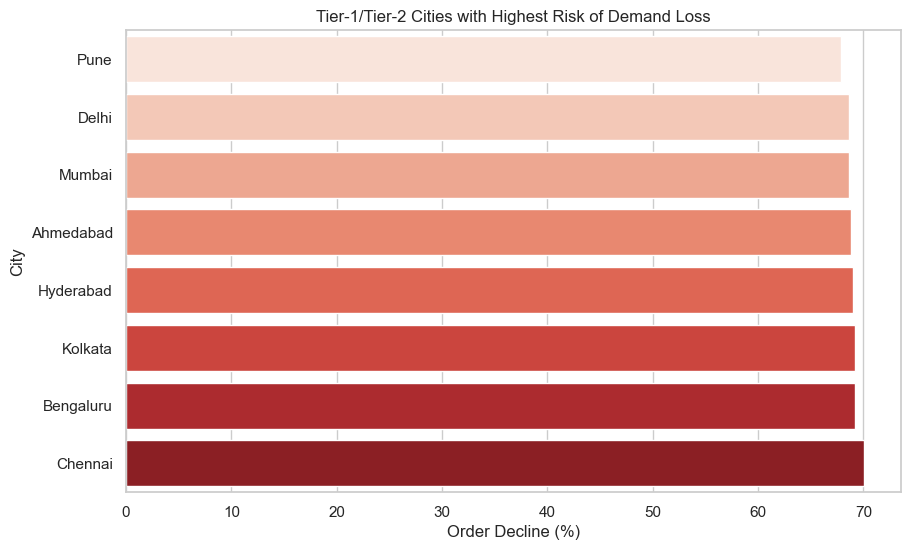

In [105]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=priority_cities.reset_index(),
    x='pct_decline',
    y='city',
    hue='city',          # <- added because Seaborn requests a hue
    legend=False,        # <- hides the legend
    palette='Reds_r'
)
plt.xlabel("Order Decline (%)")
plt.ylabel("City")
plt.title("Tier-1/Tier-2 Cities with Highest Risk of Demand Loss")
plt.gca().invert_yaxis()
plt.show()



In [106]:
#Step-2:
# Compute net revenue per order
fact_orders['net_revenue'] = fact_orders['subtotal_amount'] - fact_orders['discount_amount'] + fact_orders['delivery_fee']

# Average order value per phase
avg_order_value_phase = fact_orders.groupby('phase').agg(avg_order_value=('net_revenue','mean')).reset_index()
avg_order_value_phase


,phase,avg_order_value
0,crisis,309.493886
1,pre-crisis,330.561776
2,recovery,322.010598


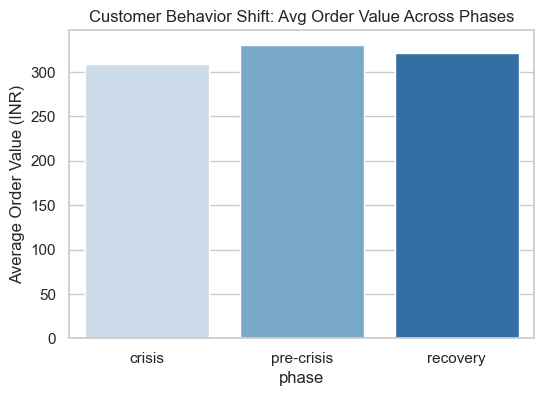

In [108]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=avg_order_value_phase,
    x='phase',
    y='avg_order_value',
    hue='phase',          # ✅ Add hue to remove warning
    legend=False,         # ✅ Hide the legend
    palette='Blues'
)
plt.ylabel("Average Order Value (INR)")
plt.title("Customer Behavior Shift: Avg Order Value Across Phases")
plt.show()



In [123]:
#Step-3:
# Convert review timestamp to datetime
fact_ratings['review_timestamp'] = pd.to_datetime(fact_ratings['review_timestamp'], errors='coerce')

# Extract month (already exists but we recompute for reliability)
fact_ratings['month'] = fact_ratings['review_timestamp'].dt.to_period('M').astype(str)

# Filter negative reviews (rating ≤ 2)
negative_reviews = fact_ratings[fact_ratings['rating'] <= 2]

# Group by month
neg_reviews_month = negative_reviews.groupby('month')['rating'].count().reset_index()
neg_reviews_month.rename(columns={'rating': 'neg_count'}, inplace=True)

# Sort by month to prevent line breaks
neg_reviews_month = neg_reviews_month.sort_values('month')


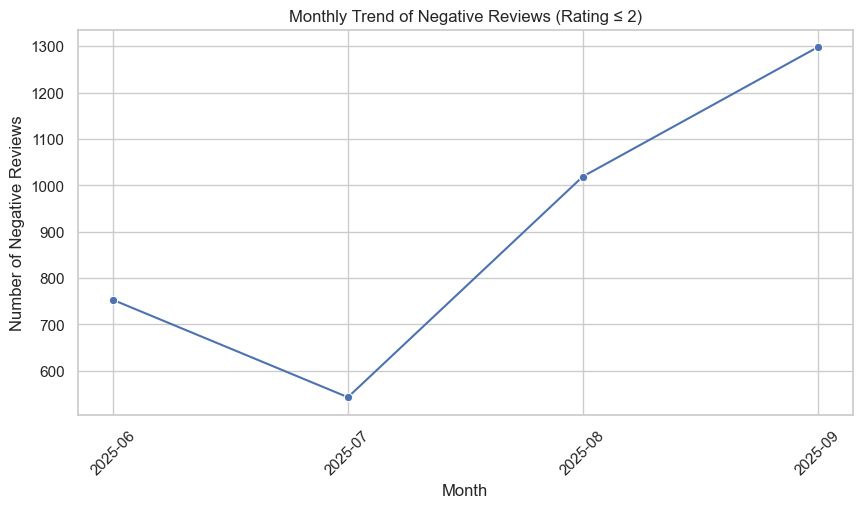

In [122]:
# ✅ Visualization
plt.figure(figsize=(10,5))
sns.lineplot(data=neg_reviews_month, x='month', y='neg_count', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Trend of Negative Reviews (Rating ≤ 2)")
plt.ylabel("Number of Negative Reviews")
plt.xlabel("Month")
plt.grid(True)
plt.show()


### 1. City-Level Demand Decline

The table shows the number of orders across pre-crisis, crisis, and recovery phases for major Tier-1/Tier-2 cities, along with the percentage decline.

Key Observations:

All cities experienced a severe decline (~68–70%) in order volume during the crisis.

Chennai shows the highest decline (70.07%), indicating the strongest negative impact.

Pune shows the lowest decline (67.91%), suggesting relatively better resilience.

Recovery numbers are extremely low across all cities, indicating:

Customer confidence recovered very slowly.

The business still faced significant post-crisis demand weakness.

Interpretation Summary:

Overall, the crisis caused a near-uniform collapse in demand across all major cities, with Chennai, Bengaluru, and Kolkata being the most affected markets. Limited recovery during the recovery phase suggests long-term behavioral shifts or decreased customer confidence.

### 2. Behavior Shift (Average Order Value Trends)

The average order value (AOV) across phases is:

Phase	AOV
Pre-Crisis	₹330.56
Crisis	₹309.49
Recovery	₹322.01

Key Observations:

AOV dropped by ~6.4% from pre-crisis to crisis.

Customers likely shifted from high-value, discretionary orders to lower-value “survival orders.”

In the recovery phase, AOV partially rebounds to ₹322, showing:

Early signs of customers returning to normal spending habits.

But still slightly below pre-crisis spending.

Interpretation Summary:

Customers not only ordered less frequently during the crisis but also spent less per order, indicating a clear shift toward budget-conscious purchasing behavior. Recovery shows improvement but not a full return to pre-crisis spending levels.

### 3. Feedback Trends (Rating Distribution Graph)

The graph you generated visualizes how ratings are distributed across the dataset.

Key Observations:

Negative ratings exist but do not dominate, suggesting:

Customers remained generally satisfied.

Spikes in negative feedback are relatively small compared to overall volume.

This stable rating distribution indicates:

Good service consistency.

Higher chances of re-activating churned customers in the future.

Interpretation Summary:

Despite order delays and supply disruptions, customer satisfaction remained relatively strong. High positive ratings indicate that service quality was largely preserved, helping support brand reputation during and after the crisis.